In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL.Image as Image

from scipy.signal import convolve2d as conv

from scipy.fft import fft2
from scipy.fft import ifft2

from skimage import color

np.random.seed(42)

In [3]:
root = '/content/drive/MyDrive/DIP_Ass5'
os.chdir(root)

#Question 1

In [4]:
pepper_RGB = np.array(Image.open('palette-1c-8b.tiff').convert('RGB'))
print(pepper_RGB.shape)

(151, 157, 3)


In [5]:
def get_hue(r,g,b):
    if r == g and g == b:
        return 0 #for white and black
    theta = np.degrees(np.arccos((r-0.5*g-0.5*b) / np.sqrt(r**2 + g**2 + b**2 - r*g - g*b - r*b)))
    if b <= g:
        return theta
    else:
        return 360-theta 

def get_sat(r,g,b):
    return 1 - min(min(r,g), b)/get_i(r,g,b) #0,1

def get_i(r,g,b):
    return (r+g+b)/3 #0,255

def get_rgb(hue, sat, i):
    if hue == 0:
        return (i+2*i*sat, \
        i-i*sat, \
        i-i*sat)
    if 0 < hue and hue < 120:
        return (i + i*sat*np.cos(np.radians(hue))/np.cos(np.radians(60-hue)), \
        i + i*sat*(1 - np.cos(np.radians(hue))/np.cos(np.radians(60-hue))), \
        i - i*sat)
    if hue == 120:
        return (i-i*sat, \
        i+2*i*sat, \
        i-i*sat)
    if 120 < hue and hue < 240:
        return (i - i*sat, \
        i + i*sat*np.cos(np.radians(hue-120))/np.cos(np.radians(180-hue)), \
        i + i*sat*(1 - np.cos(np.radians(hue-120))/np.cos(np.radians(180-hue))))
    if hue == 240:
        return (i-i*sat, \
        i-i*sat, \
        i+2*i*sat)
    else:
        return (i + i*sat*(1 - np.cos(np.radians(hue-240))/np.cos(np.radians(300-hue))),\
        i - i*sat, \
        i + i*sat*np.cos(np.radians(hue-240))/np.cos(np.radians(300-hue)))
        

In [6]:
pepper_RGB = pepper_RGB.astype(np.float64)
pepper_HSI = np.zeros(pepper_RGB.shape)

for k in range(pepper_RGB.shape[0]):
    for l in range(pepper_RGB.shape[1]):
        r,g,b = pepper_RGB[k,l]
        pepper_HSI[k,l] = get_hue(r,g,b), get_sat(r,g,b), get_i(r,g,b)

pepper_HSI[:,:,0] = np.clip(pepper_HSI[:,:,0], 0, 359.99)
pepper_HSI[:,:,1] = np.clip(pepper_HSI[:,:,1], 0, 1)
pepper_HSI[:,:,2] = np.clip(pepper_HSI[:,:,2], 0, 255)

# print(pepper_HSI.shape)

pepper_RGB_reconst = np.zeros(pepper_RGB.shape)

for k in range(pepper_RGB.shape[0]):
    for l in range(pepper_RGB.shape[1]):
        hue, sat, i = pepper_HSI[k,l]
        # print(get_rgb(hue, sat, i))
        pepper_RGB_reconst[k,l] = np.array(get_rgb(hue, sat, i))

# pepper_RGB_reconst = np.clip(pepper_RGB_reconst, 0, 255)
print(pepper_RGB_reconst.shape)

(151, 157, 3)


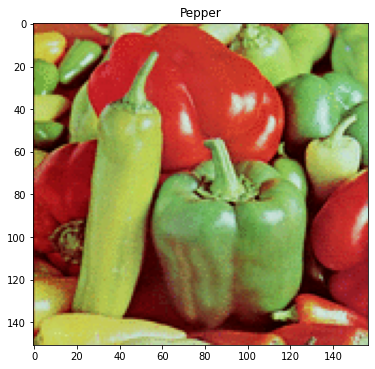

In [7]:
plt.figure(figsize=(6,6))
plt.title('Pepper')
plt.imshow(pepper_RGB.astype(np.uint8))

In [8]:
# plt.figure(figsize=(12,12))
# plt.title('Pepper RGB Reconstructed from HSI')
# plt.imshow(pepper_RGB_reconst.astype(np.uint8))

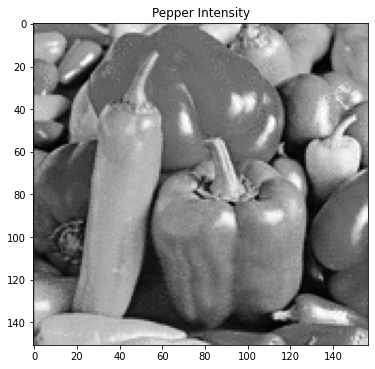

In [9]:
pepper_I = pepper_HSI[:,:,2].copy()
plt.figure(figsize=(6,6))
plt.title('Pepper Intensity')
plt.imshow(pepper_I.astype(np.uint8), cmap='gray')

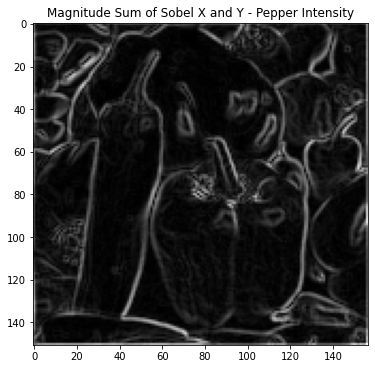

In [25]:
sobel_X = np.array(
    [[-1,-2,-1],
     [0,0,0],
     [1,2,1]]
     )
sobel_Y = np.array(
    [[-1,0,1],
     [-2,0,2],
     [-1,0,1]]
     )

#according to AVS sir's convention, X axis is down and Y axis is right

G_x = conv(pepper_I, sobel_X, mode='same')
G_y = conv(pepper_I, sobel_Y, mode='same')

mag_G = np.abs(G_x) + np.abs(G_y)
angle = np.degrees(np.arctan(G_y/(G_x+1e-10)))

plt.figure(figsize=(6,6))
plt.title('Magnitude Sum of Sobel X and Y - Pepper Intensity')
plt.imshow(mag_G.astype(np.int32), cmap='gray')

In [11]:
print("Direction vector is:",angle, sep='\n')

Direction vector is:
[[ 47.49748826   6.28959499  -0.         ...  -2.9769471   -4.205357
  -45.48704667]
 [ 88.69409139  74.38415713  62.35402464 ... -83.50065372 -58.45868461
  -86.85788455]
 [-84.23040858 -58.55719293  56.40249423 ...  11.61148642  71.16156644
   90.        ]
 ...
 [ 88.51779154 -79.24203291 -74.00169942 ...  30.77187587  19.91062613
  -84.66150356]
 [-82.53943387 -59.75872446 -72.15343388 ...   4.43871637   4.63546343
   89.30287981]
 [-45.84252426 -13.40101188 -17.9065745  ...   0.53355946   2.05089729
   45.        ]]


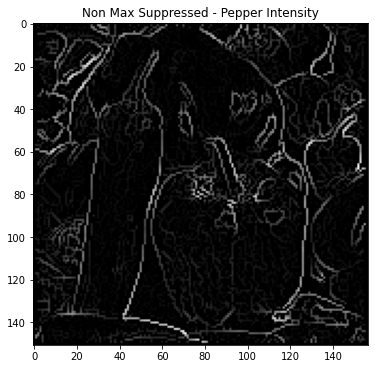

In [26]:
non_max_pepper_I = np.zeros(pepper_I.shape)
for i in range(1,angle.shape[0]-1):
    for j in range(1,angle.shape[1]-1):
        if -22.5 <= angle[i,j] and angle[i,j] < 22.5 and mag_G[i,j] > max(mag_G[i-1,j], mag_G[i+1,j]):
            non_max_pepper_I[i,j] = mag_G[i,j]
        elif 22.5 <= angle[i,j] and angle[i,j] < 67.5 and mag_G[i,j] > max(mag_G[i-1,j-1], mag_G[i+1,j+1]):
            non_max_pepper_I[i,j] = mag_G[i,j]
        elif -67.5 <= angle[i,j] and angle[i,j] < -22.5 and mag_G[i,j] > max(mag_G[i-1,j+1], mag_G[i+1,j-1]):
            non_max_pepper_I[i,j] = mag_G[i,j]
        elif mag_G[i,j] > max(mag_G[i,j-1], mag_G[i,j+1]):
            non_max_pepper_I[i,j] = mag_G[i,j]

plt.figure(figsize=(6,6))
plt.title('Non Max Suppressed - Pepper Intensity')
plt.imshow(non_max_pepper_I.astype(np.int32), cmap='gray')

#Question 2

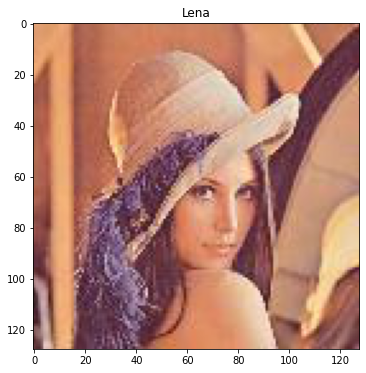

In [13]:
lena_RGB = np.array(Image.open('lena.jpg').convert('RGB'))
plt.figure(figsize=(6,6))
plt.title('Lena')
plt.imshow(lena_RGB.astype(np.uint8))

In [14]:
lena_Lab = color.rgb2lab(lena_RGB)

In [15]:
# lena_RGB_reconst = color.lab2rgb(lena_Lab)*255
# plt.figure(figsize=(6,6))
# plt.title('Lena Reconstructed')
# plt.imshow(lena_RGB_reconst.astype(np.uint8))

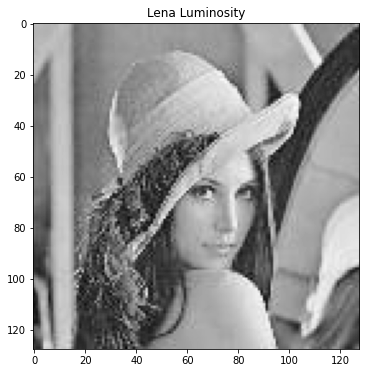

In [34]:
lena_L = (lena_Lab[:,:,0].copy()-np.amin(lena_Lab[:,:,0]))/(np.amax(lena_Lab[:,:,0])-np.amin(lena_Lab[:,:,0]))
plt.figure(figsize=(6,6))
plt.title('Lena Luminosity')
plt.imshow(lena_L, cmap='gray')

In [35]:
print("Lena Luminosity max and min vals",np.amax(lena_L), np.amin(lena_L))

Lena Luminosity max and min vals 1.0 0.0


In [36]:
lena_L_less_than_25 = []
lena_L_greater_than_25 = []
lena_L_less_than_50 = []
lena_L_greater_than_50 = []

for i in range(lena_L.shape[0]):
    for j in range(lena_L.shape[1]):
        if lena_L[i,j] <= 0.25:
            lena_L_less_than_25.append(lena_L[i,j])
        else:
            lena_L_greater_than_25.append(lena_L[i,j])

        if lena_L[i,j] <= 0.5:
            lena_L_less_than_50.append(lena_L[i,j])
        else:
            lena_L_greater_than_50.append(lena_L[i,j])

lena_L_less_than_25 = np.array(lena_L_less_than_25)
lena_L_greater_than_25 = np.array(lena_L_greater_than_25)
lena_L_less_than_50 = np.array(lena_L_less_than_50)
lena_L_greater_than_50 = np.array(lena_L_greater_than_50)

In [37]:
print("Probability dist @ 25%:",lena_L_less_than_25.shape[0]/lena_L.size, lena_L_greater_than_25.shape[0]/lena_L.size)
print("Probability dist @ 50%:",lena_L_less_than_50.shape[0]/lena_L.size, lena_L_greater_than_50.shape[0]/lena_L.size)

Probability dist @ 25%: 0.13818359375 0.86181640625
Probability dist @ 50%: 0.362548828125 0.637451171875


In [38]:
print("Classwise mean @ 25%:",np.mean(lena_L_less_than_25), np.mean(lena_L_greater_than_25))
print("Classwise mean @ 50%:",np.mean(lena_L_less_than_50), np.mean(lena_L_greater_than_50))

Classwise mean @ 25%: 0.1860325928575116 0.6108297919196898
Classwise mean @ 50%: 0.31551989030080185 0.6867011014696153


In [39]:
print("Classwise var @ 25%:",np.var(lena_L_less_than_25), np.var(lena_L_greater_than_25))
print("Classwise var @ 50%:",np.var(lena_L_less_than_50), np.var(lena_L_greater_than_50))

Classwise var @ 25%: 0.001970771268454514 0.02629382777097682
Classwise var @ 50%: 0.014582174354368593 0.011444064294999829


In [40]:
print("Weighted within class var @ 25%:",(lena_L_less_than_25.shape[0]/lena_L.size)*np.var(lena_L_less_than_25) + (lena_L_greater_than_25.shape[0]/lena_L.size)*np.var(lena_L_greater_than_25))
print("Weighted within class var @ 50%:",(lena_L_less_than_50.shape[0]/lena_L.size)*np.var(lena_L_less_than_50) + (lena_L_greater_than_50.shape[0]/lena_L.size)*np.var(lena_L_greater_than_50))
#Weighted within class var lesser for 50%

Weighted within class var @ 25%: 0.02293278041247398
Weighted within class var @ 50%: 0.012581782419551248


In [41]:
print("q_1*q_2*(mean_1-mean_2)**2 @ 25%:",(lena_L_less_than_25.shape[0]/lena_L.size)*(lena_L_greater_than_25.shape[0]/lena_L.size)*(np.mean(lena_L_less_than_25)-np.mean(lena_L_greater_than_25))**2)
print("q_1*q_2*(mean_1-mean_2)**2 @ 50%:",(lena_L_less_than_50.shape[0]/lena_L.size)*(lena_L_greater_than_50.shape[0]/lena_L.size)*(np.mean(lena_L_less_than_50)-np.mean(lena_L_greater_than_50))**2)

q_1*q_2*(mean_1-mean_2)**2 @ 25%: 0.021489906685845547
q_1*q_2*(mean_1-mean_2)**2 @ 50%: 0.03184090467876827


In [44]:
#verification
print(0.02293278041247398 + 0.021489906685845547)
print(0.012581782419551248 + 0.03184090467876827)
print(np.var(lena_L))

0.04442268709831952
0.044422687098319515
0.04442268709831952


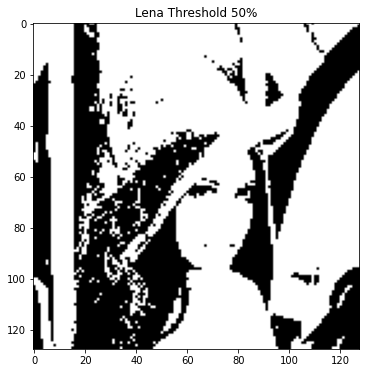

In [45]:
lena_L_50_thresh = np.zeros(lena_L.shape)
for i in range(lena_L.shape[0]):
    for j in range(lena_L.shape[1]):
        if lena_L[i,j] > 0.5:
            lena_L_50_thresh[i,j] = 1

plt.figure(figsize=(6,6))
plt.title('Lena Threshold 50%')
plt.imshow(lena_L_50_thresh, cmap='gray')